In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_crime_data(start_date='2022-01-01', periods=730, locations=['Downtown', 'Suburbs', 'Industrial']):
    """
    Generate synthetic crime data with seasonal patterns and trends
    Parameters:
    - start_date: Starting date for the dataset
    - periods: Number of days to generate data for
    - locations: List of locations to generate data for
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Create date range
    dates = pd.date_range(start=start_date, periods=periods, freq='D')
    
    # Define crime types and their typical distribution
    crime_types = {
        'Theft': 0.35,
        'Assault': 0.15,
        'Burglary': 0.20,
        'Vandalism': 0.15,
        'Drug-related': 0.15
    }
    
    data = []
    
    for location in locations:
        # Generate base pattern for each location with some variation
        location_modifier = np.random.uniform(0.8, 1.2)
        
        # Generate components for time series
        seasonal_pattern = 20 * location_modifier + 10 * np.sin(np.linspace(0, 4*np.pi, periods))
        trend = np.linspace(0, 5, periods)
        noise = np.random.normal(0, 2, periods)
        
        # Combine components
        crime_counts = seasonal_pattern + trend + noise
        crime_counts = np.maximum(crime_counts, 0)
        crime_counts = np.round(crime_counts).astype(int)
        
        for date in dates:
            daily_count = int(crime_counts[dates.get_loc(date)])
            
            # Add day-of-week effect
            if date.weekday() >= 5:  # Weekend
                daily_count = int(daily_count * 1.2)
            
            # Distribute crimes among types
            type_distribution = np.random.multinomial(
                daily_count, 
                list(crime_types.values())
            )
            
            for crime_type, count in zip(crime_types.keys(), type_distribution):
                if count > 0:
                    data.append({
                        'Date': date,
                        'Location': location,
                        'CrimeType': crime_type,
                        'Count': count,
                        'DayOfWeek': date.day_name(),
                        'Month': date.month_name(),
                        'Year': date.year,
                        'Temperature': np.random.normal(20, 5) + 10 * np.sin(2 * np.pi * date.dayofyear / 365),  # Simulated temperature
                        'IsWeekend': date.weekday() >= 5
                    })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Save to CSV
    filename = 'crime_data.csv'
    df.to_csv(filename, index=False)
    print(f"Dataset generated and saved to {filename}")
    
    return df


    # Generate data
df = generate_crime_data()
    
    # Print summary statistics
print("\nDataset Summary:")
print("\nTotal number of records:", len(df))
print("\nCrime counts by location:")
print(df.groupby('Location')['Count'].sum())
print("\nCrime counts by type:")
print(df.groupby('CrimeType')['Count'].sum())
print("\nDate range:", df['Date'].min(), "to", df['Date'].max())

Dataset generated and saved to crime_data.csv

Dataset Summary:

Total number of records: 10611

Crime counts by location:
Location
Downtown      16561
Industrial    16853
Suburbs       17777
Name: Count, dtype: int32

Crime counts by type:
CrimeType
Assault          7591
Burglary        10160
Drug-related     7614
Theft           18120
Vandalism        7706
Name: Count, dtype: int32

Date range: 2022-01-01 00:00:00 to 2023-12-31 00:00:00


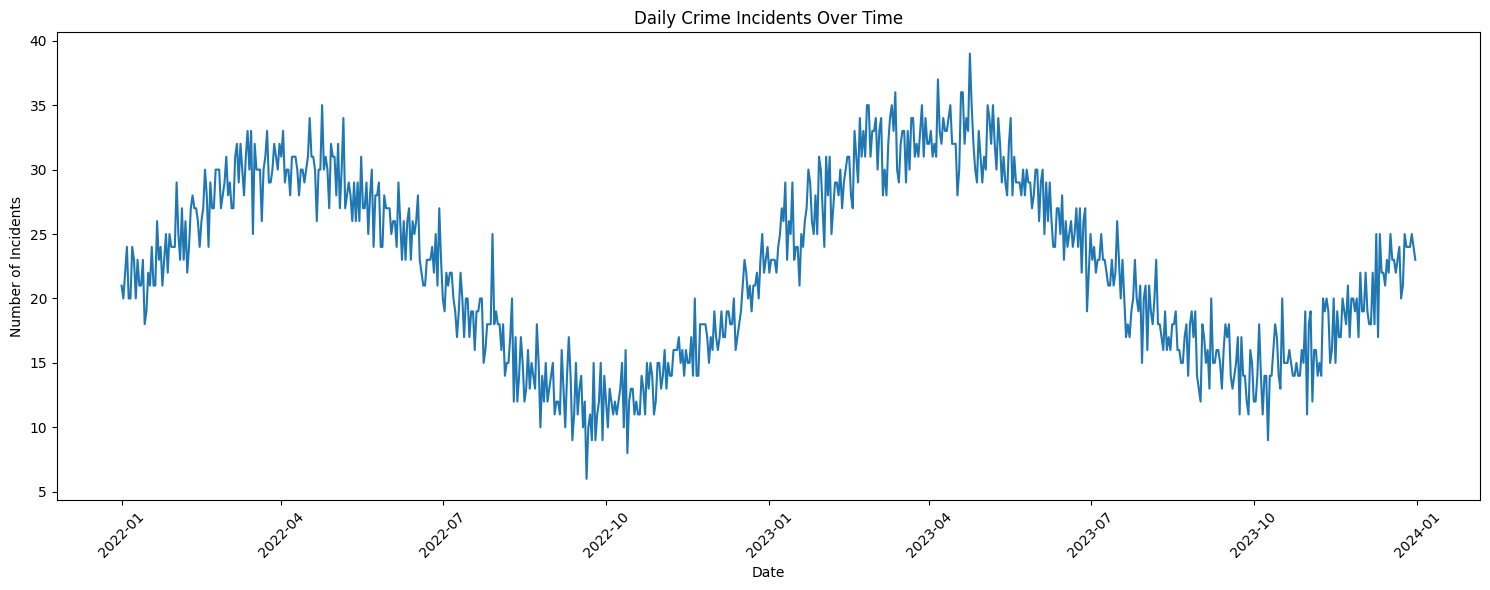


Augmented Dickey-Fuller Test:
ADF Statistic: -1.5948019122735226
p-value: 0.48620414841691545

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  730
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1603.207
Date:                Sun, 17 Nov 2024   AIC                           3212.414
Time:                        17:01:35   BIC                           3226.189
Sample:                    01-01-2022   HQIC                          3217.728
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0740      0.046     -1.592      0.111      -0.165       0.017
ma.L1         

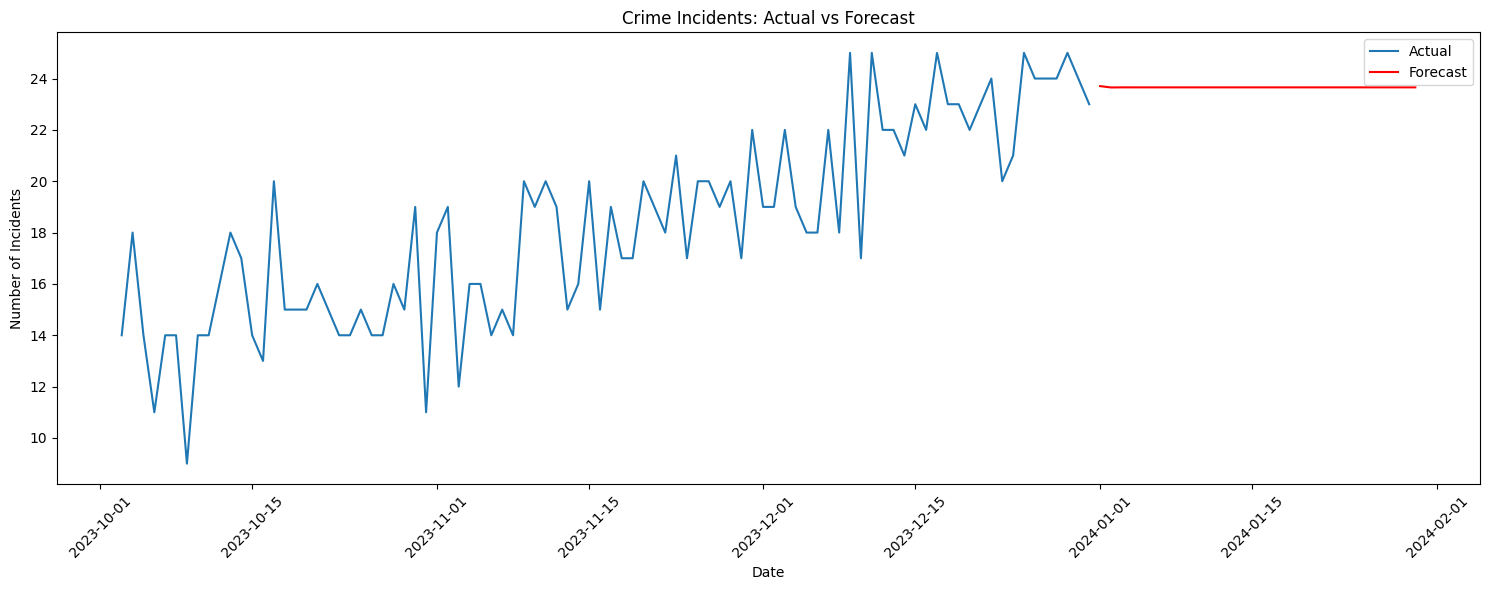

<Figure size 1500x600 with 0 Axes>

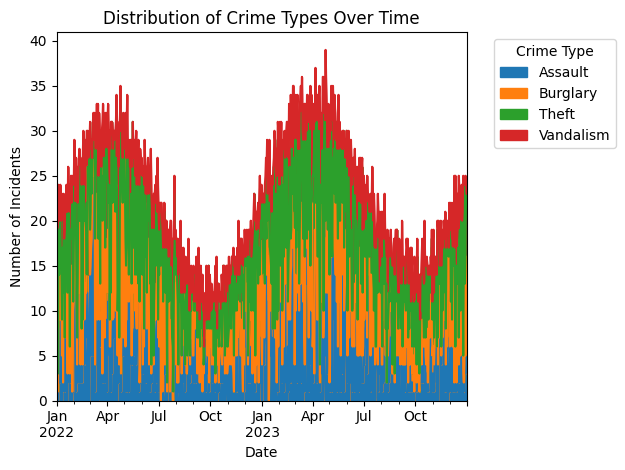


Forecast for the next 30 days:
             Forecast
Date                 
2024-01-01  23.704945
2024-01-02  23.652790
2024-01-03  23.656649
2024-01-04  23.656363
2024-01-05  23.656384


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt

def analyze_crime_data(file_path='crime_data.csv'):
    
    print("Supreetha.H.R\n21BBS0131")

    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])

    daily_totals = df.groupby('Date')['Count'].sum().reset_index()
    daily_totals.set_index('Date', inplace=True)
 
    plt.figure(figsize=(15, 6))
    plt.plot(daily_totals.index, daily_totals['Count'])
    plt.title('Daily Crime Incidents Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Incidents')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    adf_result = adfuller(daily_totals['Count'])
    print('\nAugmented Dickey-Fuller Test:')
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    
    model = ARIMA(daily_totals['Count'], order=(1,1,1))
    results = model.fit()
    print('\nARIMA Model Summary:')
    print(results.summary())
    
    forecast_steps = 30
    forecast = results.forecast(steps=forecast_steps)
 
    last_date = daily_totals.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                 periods=forecast_steps, 
                                 freq='D')
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Forecast': forecast
    })
    forecast_df.set_index('Date', inplace=True)

    plt.figure(figsize=(15, 6))
    plt.plot(daily_totals.index[-90:], daily_totals['Count'][-90:], label='Actual')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.title('Crime Incidents: Actual vs Forecast')
    plt.xlabel('Date')
    plt.ylabel('Number of Incidents')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    crime_by_type = df.groupby(['Date', 'CrimeType'])['Count'].sum().unstack()
 
    plt.figure(figsize=(15, 6))
    crime_by_type.plot(kind='area', stacked=True)
    plt.title('Distribution of Crime Types Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Incidents')
    plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return results, forecast_df

if __name__ == "__main__":
    results, forecast = analyze_crime_data()
    print("\nForecast for the next 30 days:")
    print(forecast.head())

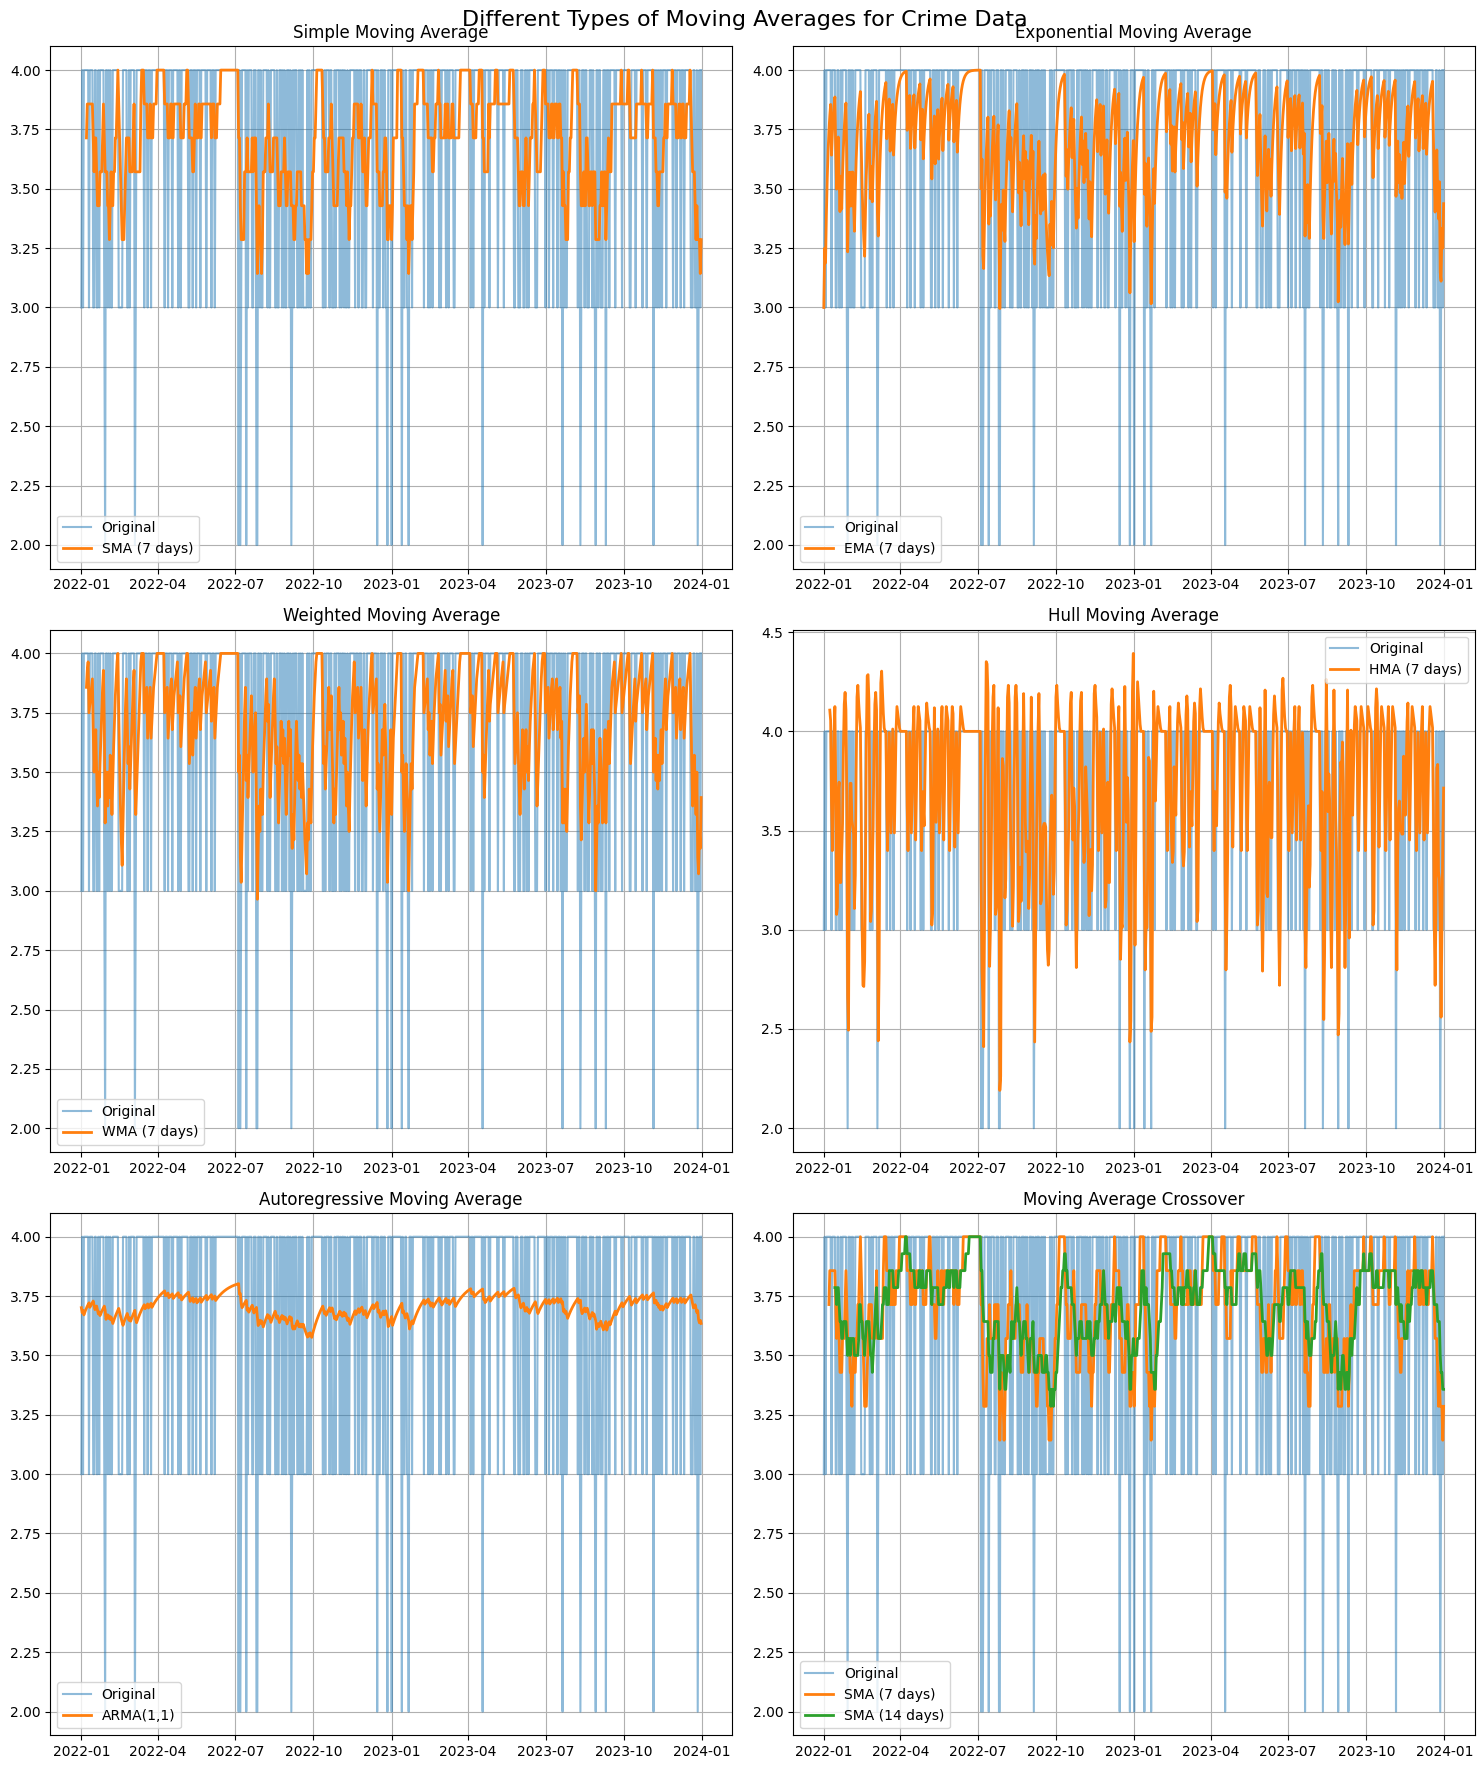

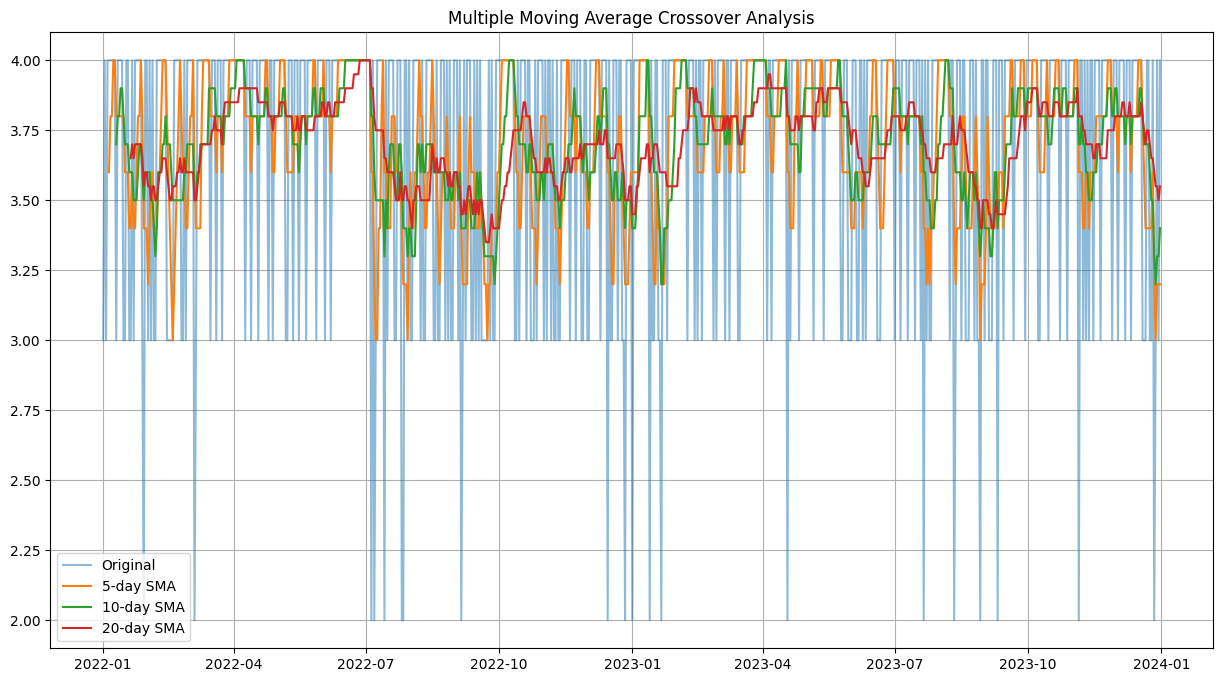

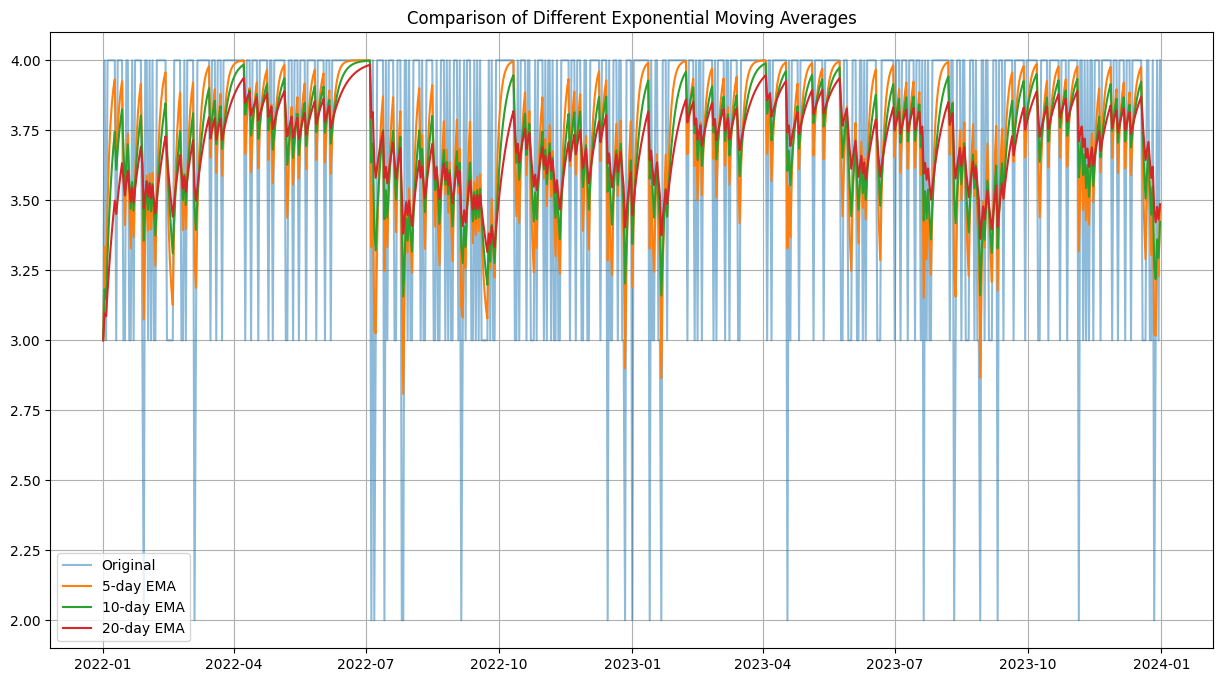


Summary Statistics for Different Moving Averages:
         Original         SMA         EMA         WMA         HMA        ARMA
count  730.000000  724.000000  730.000000  724.000000  723.000000  730.000000
mean     3.704110    3.705998    3.702313    3.705406    3.703427    3.703647
std      0.513317    0.205601    0.210295    0.227880    0.413362    0.044406
min      2.000000    3.142857    2.995207    2.964286    2.190476    3.575980
25%      3.000000    3.571429    3.555107    3.535714    3.452381    3.671180
50%      4.000000    3.714286    3.734273    3.750000    3.750000    3.707773
75%      4.000000    3.857143    3.873469    3.892857    4.017857    3.737388
max      4.000000    4.000000    3.999854    4.000000    4.392857    3.802246


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

print("Supreetha.H.R\n21BBS0131")

df = pd.read_csv('crime_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

daily_crimes = df.groupby(['Date']).size().reset_index(name='Count')
daily_crimes.set_index('Date', inplace=True)

class MovingAveragesAnalyzer:
    def __init__(self, data): 
        self.data = data
        
    def simple_moving_average(self, window):
        """Calculate Simple Moving Average"""
        return self.data.rolling(window=window).mean()
    
    def exponential_moving_average(self, span):
        """Calculate Exponential Moving Average"""
        return self.data.ewm(span=span, adjust=False).mean()
    
    def weighted_moving_average(self, window):
        """Calculate Weighted Moving Average"""
        weights = np.arange(1, window + 1)
        return self.data.rolling(window=window).apply(
            lambda x: np.dot(x, weights) / weights.sum()
        )
    
    def hull_moving_average(self, window):
        """Calculate Hull Moving Average"""
        wma_half = self.weighted_moving_average(window // 2)
        wma_full = self.weighted_moving_average(window)
        hull = 2 * wma_half - wma_full
        return hull.rolling(window=int(np.sqrt(window))).mean()
    
    def arma_process(self, ar_order=1, ma_order=1):
        """Calculate ARMA process"""
        model = ARIMA(self.data, order=(ar_order, 0, ma_order))
        results = model.fit()
        return pd.Series(results.fittedvalues, index=self.data.index)

    def plot_all_averages(self):
        window = 7  
        sma = self.simple_moving_average(window)
        ema = self.exponential_moving_average(window)
        wma = self.weighted_moving_average(window)
        hma = self.hull_moving_average(window)
        arma = self.arma_process()

        
        fig, axes = plt.subplots(3, 2, figsize=(15, 18))
        fig.suptitle('Different Types of Moving Averages for Crime Data', fontsize=16)

        # 1. Simple Moving Average
        axes[0, 0].plot(self.data, label='Original', alpha=0.5)
        axes[0, 0].plot(sma, label=f'SMA ({window} days)', linewidth=2)
        axes[0, 0].set_title('Simple Moving Average')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # 2. Exponential Moving Average
        axes[0, 1].plot(self.data, label='Original', alpha=0.5)
        axes[0, 1].plot(ema, label=f'EMA ({window} days)', linewidth=2)
        axes[0, 1].set_title('Exponential Moving Average')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # 3. Weighted Moving Average
        axes[1, 0].plot(self.data, label='Original', alpha=0.5)
        axes[1, 0].plot(wma, label=f'WMA ({window} days)', linewidth=2)
        axes[1, 0].set_title('Weighted Moving Average')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # 4. Hull Moving Average
        axes[1, 1].plot(self.data, label='Original', alpha=0.5)
        axes[1, 1].plot(hma, label=f'HMA ({window} days)', linewidth=2)
        axes[1, 1].set_title('Hull Moving Average')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        # 5. ARMA Process
        axes[2, 0].plot(self.data, label='Original', alpha=0.5)
        axes[2, 0].plot(arma, label='ARMA(1,1)', linewidth=2)
        axes[2, 0].set_title('Autoregressive Moving Average')
        axes[2, 0].legend()
        axes[2, 0].grid(True)

        # 6. Moving Average Crossover
        axes[2, 1].plot(self.data, label='Original', alpha=0.5)
        axes[2, 1].plot(sma, label=f'SMA ({window} days)', linewidth=2)
        axes[2, 1].plot(self.simple_moving_average(14), 
                       label='SMA (14 days)', linewidth=2)
        axes[2, 1].set_title('Moving Average Crossover')
        axes[2, 1].legend()
        axes[2, 1].grid(True)

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15, 8))
        plt.plot(self.data, label='Original', alpha=0.5)
        plt.plot(self.simple_moving_average(5), label='5-day SMA')
        plt.plot(self.simple_moving_average(10), label='10-day SMA')
        plt.plot(self.simple_moving_average(20), label='20-day SMA')
        plt.title('Multiple Moving Average Crossover Analysis')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(15, 8))
        plt.plot(self.data, label='Original', alpha=0.5)
        plt.plot(self.exponential_moving_average(5), label='5-day EMA')
        plt.plot(self.exponential_moving_average(10), label='10-day EMA')
        plt.plot(self.exponential_moving_average(20), label='20-day EMA')
        plt.title('Comparison of Different Exponential Moving Averages')
        plt.legend()
        plt.grid(True)
        plt.show()

analyzer = MovingAveragesAnalyzer(daily_crimes['Count'])
analyzer.plot_all_averages()

print("\nSummary Statistics for Different Moving Averages:")
window = 7
sma = analyzer.simple_moving_average(window)
ema = analyzer.exponential_moving_average(window)
wma = analyzer.weighted_moving_average(window)
hma = analyzer.hull_moving_average(window)
arma = analyzer.arma_process()

summary_df = pd.DataFrame({
    'Original': daily_crimes['Count'],
    'SMA': sma,
    'EMA': ema,
    'WMA': wma,
    'HMA': hma,
    'ARMA': arma
}).describe()

print(summary_df)


In [19]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_crime_data(start_date='2022-01-01', num_days=730):
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Generate dates
    dates = [datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=x) for x in range(num_days)]
    
    # Create base number of incidents with seasonal pattern
    base_incidents = 20 + 10 * np.sin(np.linspace(0, 4*np.pi, num_days))  # Seasonal pattern
    
    # Add trend
    trend = np.linspace(0, 5, num_days)  # Slight upward trend
    
    # Add random noise
    noise = np.random.normal(0, 2, num_days)
    
    # Combine components
    incidents = base_incidents + trend + noise
    
    # Ensure all values are positive and round to integers
    incidents = np.maximum(incidents, 0)
    incidents = np.round(incidents).astype(int)
    
    # Create crime types
    crime_types = ['Theft', 'Assault', 'Burglary', 'Vandalism']
    
    # Generate data for each crime type
    data = []
    for date in dates:
        daily_total = incidents[dates.index(date)]
        # Distribute total incidents among crime types
        type_distribution = np.random.dirichlet(np.ones(len(crime_types)))
        type_counts = np.round(daily_total * type_distribution).astype(int)
        
        # Adjust to ensure sum matches daily total
        while sum(type_counts) != daily_total:
            if sum(type_counts) < daily_total:
                type_counts[np.random.randint(0, len(crime_types))] += 1
            else:
                type_counts[np.random.randint(0, len(crime_types))] -= 1
        
        for crime_type, count in zip(crime_types, type_counts):
            if count > 0:
                data.append({
                    'Date': date,
                    'CrimeType': crime_type,
                    'Count': count,
                    'Location': 'Downtown',  # You can add multiple locations if needed
                })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Save to CSV
    df.to_csv('crime_data.csv', index=False)
    print("Data saved to crime_data.csv")
    return df

if __name__ == "__main__":
    df = generate_crime_data()
    print("\nFirst few rows of generated data:")
    print(df.head())
    print("\nData shape:", df.shape)

Data saved to crime_data.csv

First few rows of generated data:
        Date  CrimeType  Count  Location
0 2022-01-01    Assault     15  Downtown
1 2022-01-01   Burglary      1  Downtown
2 2022-01-01  Vandalism      5  Downtown
3 2022-01-02      Theft      2  Downtown
4 2022-01-02    Assault      4  Downtown

Data shape: (2704, 4)
